In [317]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot

from numpy import arange
# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import ElasticNet

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error as mse


import sqlite3
import seaborn as sns
import plotly.express as px

pd.options.display.max_rows = 4000

from pandasql import sqldf


In [225]:
#pip install pandasql

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26781 sha256=9daa8e5ca5631276475fb950667076555dd9823413ccc13c6e764140c082fbdd
  Stored in directory: c:\users\weijili\appdata\local\pip\cache\wheels\ed\8f\46\a383923333728744f01ba24adbd8e364f2cb9470a8b8e5b9ff
Successfully built pandasql
Note: you may need to restart the kernel to use updated packages.


In [280]:
game_df = pd.read_csv('game.csv')

In [281]:
game_df.head()

,Unnamed: 0,GAME_ID,SEASON_ID,TEAM_ID_HOME,TEAM_ID_AWAY,GAME_DATE,SEASON,LAST_GAME_ID,LAST_GAME_HOME_TEAM_ID,LAST_GAME_VISITOR_TEAM_ID,...,PTS_OT3_AWAY,PTS_OT4_AWAY,LAST_GAME_HOME_TEAM_POINTS,LAST_GAME_VISITOR_TEAM_POINTS,HOME_TEAM_WINS,HOME_TEAM_LOSSES,SERIES_LEADER,PT_AVAILABLE,PT_XYZ_AVAILABLE,HUSTLE_STATUS
0,0,29600002,21996,1610612751,1610612739,1996-11-01,1996,29500765.0,1.610613e+09,1.610613e+09,...,0.0,0.0,74.0,103.0,0.0,4.0,Cleveland,0.0,0.0,0.0
1,1,29600009,21996,1610612745,1610612758,1996-11-01,1996,29501059.0,1.610613e+09,1.610613e+09,...,0.0,0.0,91.0,96.0,4.0,0.0,Houston,0.0,0.0,0.0
2,2,29600010,21996,1610612743,1610612742,1996-11-01,1996,29501162.0,1.610613e+09,1.610613e+09,...,0.0,0.0,98.0,132.0,1.0,3.0,Dallas,0.0,0.0,0.0
3,3,29600011,21996,1610612762,1610612760,1996-11-01,1996,49500062.0,1.610613e+09,1.610613e+09,...,0.0,0.0,86.0,90.0,3.0,1.0,Utah,0.0,0.0,0.0
4,4,29600003,21996,1610612755,1610612749,1996-11-01,1996,29500680.0,1.610613e+09,1.610613e+09,...,0.0,0.0,104.0,101.0,1.0,3.0,Milwaukee,0.0,0.0,0.0


Create Win loss variable for home game due to missing value

In [282]:
conditions = [
    (game_df['PLUS_MINUS_HOME'] < 0),
    (game_df['PLUS_MINUS_HOME'] == 0),
    (game_df['PLUS_MINUS_HOME'] > 0)
    ]

# create a list of the values we want to assign for each condition
values = ['L', 'T', 'W']

# create a new column and use np.select to assign values to it using our lists as arguments
game_df['WL_Home_modified'] = np.select(conditions, values)

In [283]:
Game_modified = game_df.copy()

Drop columns that are not usefull for the model

In [284]:
Game_modified = Game_modified.drop(['SEASON_ID','GAME_SEQUENCE', 'LAST_GAME_ID','LAST_GAME_HOME_TEAM_ID',
                                    'LAST_GAME_VISITOR_TEAM_ID','LAST_GAME_DATE_EST',
                                    'PTS_AWAY','PTS_HOME','WL_HOME','MIN_AWAY','HOME_TEAM_WINS', 'HOME_TEAM_LOSSES',
                                   'LAST_GAME_HOME_TEAM_POINTS', 'LAST_GAME_VISITOR_TEAM_POINTS',
                                    'SERIES_LEADER','ATTENDANCE','GAME_STATUS_TEXT','Unnamed: 0'
                                   ], axis = 1)

DROP: FGM, FG3M, FTM, REB, GP, MIN.    
FGM, FG3M, FTM are linear combinations of (FGA, FG3A, FT_PCT) * (FG_PCT, FG3_PCT, FT_PCT)     respectively.    
REB is a linear combination of DREB + OREB.    

In [285]:
Game_modified = Game_modified.drop(['FGM_HOME','FG3M_HOME','FTM_HOME','REB_HOME',
                                    'FGM_AWAY','FG3M_AWAY','FTM_AWAY','REB_AWAY',
                                   ], axis = 1)

Cast features to the correct data types

In [287]:
Game_modified = Game_modified[game_df['SEASON'].astype('int')>=2004]

In [288]:
Game_modified.convert_dtypes().dtypes   

GAME_ID                   Int64
TEAM_ID_HOME              Int64
TEAM_ID_AWAY              Int64
GAME_DATE                string
SEASON                    Int64
PLUS_MINUS_HOME           Int64
MIN_HOME                  Int64
FGA_HOME                  Int64
FG_PCT_HOME             float64
FG3A_HOME                 Int64
FG3_PCT_HOME            float64
FTA_HOME                  Int64
FT_PCT_HOME             float64
OREB_HOME                 Int64
DREB_HOME                 Int64
AST_HOME                  Int64
STL_HOME                  Int64
BLK_HOME                  Int64
TOV_HOME                  Int64
PF_HOME                   Int64
FGA_AWAY                  Int64
FG_PCT_AWAY             float64
FG3A_AWAY                 Int64
FG3_PCT_AWAY            float64
FTA_AWAY                  Int64
FT_PCT_AWAY             float64
OREB_AWAY                 Int64
DREB_AWAY                 Int64
AST_AWAY                  Int64
STL_AWAY                  Int64
BLK_AWAY                  Int64
TOV_AWAY

In [289]:
Game_modified[['SEASON']] = Game_modified[['SEASON']].astype(int)

In [290]:
Game_modified[['FGA_HOME','FG3A_HOME','OREB_HOME','DREB_HOME','AST_HOME',
               'STL_HOME','BLK_HOME','TOV_HOME','FGA_AWAY','FG3A_AWAY','FT_PCT_AWAY',
               'OREB_AWAY','DREB_AWAY','AST_AWAY','STL_AWAY','BLK_AWAY','TOV_AWAY',
               'PTS_PAINT_HOME','PTS_2ND_CHANCE_HOME','PTS_FB_HOME','LARGEST_LEAD_HOME',
               'LEAD_CHANGES_HOME','TIMES_TIED_HOME','TEAM_TURNOVERS_HOME','TOTAL_TURNOVERS_HOME',
               'TEAM_REBOUNDS_HOME','PTS_OFF_TO_HOME','PTS_PAINT_AWAY','PTS_2ND_CHANCE_AWAY',
               'PTS_FB_AWAY','LARGEST_LEAD_AWAY','LEAD_CHANGES_AWAY','TIMES_TIED_AWAY',
               'TEAM_TURNOVERS_AWAY','TOTAL_TURNOVERS_AWAY','TEAM_REBOUNDS_AWAY','PTS_OFF_TO_AWAY',
               'PTS_QTR1_HOME','PTS_QTR2_HOME','PTS_QTR3_HOME','PTS_QTR4_HOME','PTS_OT1_HOME',
               'PTS_OT2_HOME','PTS_OT3_HOME','PTS_OT4_HOME','PTS_QTR1_AWAY','PTS_QTR2_AWAY','PTS_QTR3_AWAY',
               'PTS_QTR4_AWAY','PTS_OT1_AWAY','PTS_OT2_AWAY','PTS_OT3_AWAY','PTS_OT4_AWAY']] = Game_modified[[
                'FGA_HOME','FG3A_HOME','OREB_HOME','DREB_HOME','AST_HOME',
               'STL_HOME','BLK_HOME','TOV_HOME','FGA_AWAY','FG3A_AWAY','FT_PCT_AWAY',
               'OREB_AWAY','DREB_AWAY','AST_AWAY','STL_AWAY','BLK_AWAY','TOV_AWAY',
               'PTS_PAINT_HOME','PTS_2ND_CHANCE_HOME','PTS_FB_HOME','LARGEST_LEAD_HOME',
               'LEAD_CHANGES_HOME','TIMES_TIED_HOME','TEAM_TURNOVERS_HOME','TOTAL_TURNOVERS_HOME',
               'TEAM_REBOUNDS_HOME','PTS_OFF_TO_HOME','PTS_PAINT_AWAY','PTS_2ND_CHANCE_AWAY',
               'PTS_FB_AWAY','LARGEST_LEAD_AWAY','LEAD_CHANGES_AWAY','TIMES_TIED_AWAY',
               'TEAM_TURNOVERS_AWAY','TOTAL_TURNOVERS_AWAY','TEAM_REBOUNDS_AWAY','PTS_OFF_TO_AWAY',
               'PTS_QTR1_HOME','PTS_QTR2_HOME','PTS_QTR3_HOME','PTS_QTR4_HOME','PTS_OT1_HOME',
               'PTS_OT2_HOME','PTS_OT3_HOME','PTS_OT4_HOME','PTS_QTR1_AWAY','PTS_QTR2_AWAY','PTS_QTR3_AWAY',
               'PTS_QTR4_AWAY','PTS_OT1_AWAY','PTS_OT2_AWAY','PTS_OT3_AWAY','PTS_OT4_AWAY']].astype(float)

Check for NAs and removed NAs due to small proportion

In [291]:
Game_modified.isnull().sum()

GAME_ID                    0
TEAM_ID_HOME               0
TEAM_ID_AWAY               0
GAME_DATE                  0
SEASON                     0
PLUS_MINUS_HOME            0
MIN_HOME                   0
FGA_HOME                   0
FG_PCT_HOME                0
FG3A_HOME                  0
FG3_PCT_HOME               0
FTA_HOME                   0
FT_PCT_HOME                0
OREB_HOME                  0
DREB_HOME                  0
AST_HOME                   0
STL_HOME                   0
BLK_HOME                   0
TOV_HOME                   0
PF_HOME                    0
FGA_AWAY                   0
FG_PCT_AWAY                0
FG3A_AWAY                  0
FG3_PCT_AWAY               0
FTA_AWAY                   0
FT_PCT_AWAY                0
OREB_AWAY                  0
DREB_AWAY                  0
AST_AWAY                   0
STL_AWAY                   0
BLK_AWAY                   0
TOV_AWAY                   0
PF_AWAY                    0
PTS_PAINT_HOME            68
PTS_2ND_CHANCE

In [292]:
Game_modified = Game_modified.dropna()

In [294]:
Game_modified

,GAME_ID,TEAM_ID_HOME,TEAM_ID_AWAY,GAME_DATE,SEASON,PLUS_MINUS_HOME,MIN_HOME,FGA_HOME,FG_PCT_HOME,FG3A_HOME,...,PTS_QTR3_AWAY,PTS_QTR4_AWAY,PTS_OT1_AWAY,PTS_OT2_AWAY,PTS_OT3_AWAY,PTS_OT4_AWAY,PT_AVAILABLE,PT_XYZ_AVAILABLE,HUSTLE_STATUS,WL_Home_modified
9062,20400015,1610612746,1610612760,2004-11-03,2004,30,240,70.0,0.629,9.0,...,20.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,W
9063,20400005,1610612753,1610612749,2004-11-03,2004,1,240,92.0,0.446,13.0,...,20.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,W
9064,20400011,1610612750,1610612752,2004-11-03,2004,6,240,79.0,0.494,16.0,...,25.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,W
9065,20400007,1610612738,1610612755,2004-11-03,2004,-3,240,69.0,0.478,17.0,...,20.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L
9077,20400025,1610612741,1610612751,2004-11-05,2004,-5,290,105.0,0.371,34.0,...,18.0,21.0,5.0,12.0,0.0,0.0,0.0,0.0,0.0,L
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29460,22001076,1610612757,1610612743,2021-05-16,2020,16,240,87.0,0.529,43.0,...,29.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,W
29461,22001071,1610612750,1610612742,2021-05-16,2020,15,240,90.0,0.544,40.0,...,35.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,W
29462,22001068,1610612741,1610612749,2021-05-16,2020,6,240,87.0,0.517,32.0,...,31.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,W
29463,22001072,1610612740,1610612747,2021-05-16,2020,-12,240,78.0,0.474,25.0,...,28.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L


In [296]:
Game_modified.to_csv('game_cleaned.csv', sep=',')

**Game data**    
outcome label: margin of victory of the game    
training features:     
- if teams in the current season have enough history:    
    - take the average of each game stats prior to current game in the season
- if the teams have less than 10 current season games, 
    - take the weighted average of each game stats prior to the current season and the games stats in the current season prior to the current game up to 10 games. 
- If there are not enough prior season games to make up 10 games in total:
    - the weighted average is adjusted to the number of games available.
    

Generate order for games per team at each season

In [266]:
Game_modified_ordered = sqldf(
    '''
        select *,
            row_number() over (partition by TEAM_ID_HOME, SEASON order by GAME_DATE) as game_order,
            row_number() over (partition by TEAM_ID_HOME, SEASON order by GAME_DATE desc) as game_reverse_order,
            count(GAME_ID) over (partition by TEAM_ID_HOME, SEASON) as total_game_count
        from Game_modified
    '''
)
Game_modified_ordered

,GAME_ID,TEAM_ID_HOME,TEAM_ID_AWAY,GAME_DATE,SEASON,PLUS_MINUS_HOME,MIN_HOME,FGA_HOME,FG_PCT_HOME,FG3A_HOME,...,PTS_OT2_AWAY,PTS_OT3_AWAY,PTS_OT4_AWAY,PT_AVAILABLE,PT_XYZ_AVAILABLE,HUSTLE_STATUS,WL_Home_modified,game_order,game_reverse_order,total_game_count
0,20400946,1610612737,1610612764,2005-03-16,2004,-29,240,82.0,0.439,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,L,1,1,1
1,20500051,1610612737,1610612747,2005-11-08,2005,-6,240,75.0,0.493,15.0,...,0.0,0.0,0.0,0.0,0.0,0.0,L,1,41,41
2,20500068,1610612737,1610612746,2005-11-10,2005,-7,240,91.0,0.407,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,L,2,40,41
3,20500082,1610612737,1610612763,2005-11-12,2005,-1,240,83.0,0.398,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,L,3,39,41
4,20500156,1610612737,1610612738,2005-11-23,2005,3,240,72.0,0.556,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,W,4,38,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19188,22000434,1610612766,1610612741,2021-05-06,2020,-21,240,90.0,0.422,35.0,...,0.0,0.0,0.0,0.0,0.0,1.0,L,32,5,36
19189,22001004,1610612766,1610612753,2021-05-07,2020,10,240,89.0,0.494,33.0,...,0.0,0.0,0.0,0.0,0.0,1.0,W,33,4,36
19190,22001020,1610612766,1610612740,2021-05-09,2020,-2,240,95.0,0.442,37.0,...,0.0,0.0,0.0,1.0,0.0,1.0,L,34,3,36
19191,22000448,1610612766,1610612743,2021-05-11,2020,-5,240,91.0,0.462,39.0,...,0.0,0.0,0.0,0.0,0.0,1.0,L,35,2,36


In [256]:
Game_modified_ordered[(Game_modified_ordered['TEAM_ID_HOME'] == 1610612737) & 
              (Game_modified_ordered['SEASON'] == 2005) & 
              (Game_modified_ordered['game_order'] < 28)]['MIN_HOME'].mean()


241.85185185185185

In [259]:
game_past_data = Game_modified_ordered.copy()

fields don't change with past average:
GAME_ID    
TEAM_ID_HOME    
TEAM_ID_AWAY    
GAME_DATE    
SEASON    
PLUS_MINUS_HOME    
WL_Home_modified    


In [272]:
# iterate through all columns in the data
for column in game_past_data:
    
    #skip columns that not game states
    if column not in ['GAME_ID','TEAM_ID_HOME','TEAM_ID_AWAY','GAME_DATE',
                      'SEASON','PLUS_MINUS_HOME','WL_Home_modified',
                      'game_order','game_reverse_order','total_game_count']:
        
        for i in range(game_past_data.shape[0]):
            
            current_season_count = game_past_data.iloc[i]['game_order']
            game_id = game_past_data.iloc[i]['GAME_ID']
            team = game_past_data.iloc[i]['TEAM_ID_HOME']
            season = game_past_data.iloc[i]['SEASON']
            
            
            # if there's enough history in current season, 
            # take average of game stats prior to  current game
            if current_season_count>10:
                game_past_data.loc[game_past_data['GAME_ID']== game_id,column] = \
                Game_modified_ordered[(Game_modified_ordered['TEAM_ID_HOME'] == team) & 
                              (Game_modified_ordered['SEASON'] == season) & 
                              (Game_modified_ordered['game_order'] < current_season_count)][column].mean()
            
            # if there's not enough history in current season
            elif game_past_data.iloc[i]['SEASON'] >= 2005: 
                
                # calculated the number of past season games needed to make 10 games history
                past_season_count_needed = 10 - (current_season_count - 1)
                
                # check the total number of past season games history available
                past_season_max = Game_modified_ordered[(Game_modified_ordered['TEAM_ID_HOME'] == team) & 
                              (Game_modified_ordered['SEASON'] == season-1)]['total_game_count'].mean()
                
                # if we have enough history from the past season, 
                # calculated the weight for current season and past season
                if past_season_count_needed <= past_season_max:
                    current_season_ratio = (current_season_count - 1)/10
                    past_season_ratio = past_season_count_needed/10
                    past_season_threshold = past_season_count_needed
                
                else:
                # if we do not have enough history from the past season, 
                # calculated the weight for current season and past season based on 
                # the total history available from current season and past season
                    current_season_ratio = (current_season_count - 1)/((current_season_count - 1)+past_season_max)
                    past_season_ratio = past_season_max/((current_season_count - 1)+past_season_max)
                    past_season_threshold = past_season_max
                    
                    
                game_past_data.loc[game_past_data['GAME_ID']== game_past_data.iloc[i]['GAME_ID'],column] = \
                current_season_ratio * Game_modified_ordered[(Game_modified_ordered['TEAM_ID_HOME'] == team) & 
                              (Game_modified_ordered['SEASON'] == season) & 
                              (Game_modified_ordered['game_order'] < current_season_count)][column].mean() + \
                past_season_ratio * Game_modified_ordered[(Game_modified_ordered['TEAM_ID_HOME'] == team) & 
                              (Game_modified_ordered['SEASON'] == season - 1) & 
                              (Game_modified_ordered['game_reverse_order'] <= past_season_threshold)][column].mean()
    
    # this was for check on progress
    print(column)
            

GAME_ID
TEAM_ID_HOME
TEAM_ID_AWAY
GAME_DATE
SEASON
PLUS_MINUS_HOME
MIN_HOME
FGA_HOME
FG_PCT_HOME
FG3A_HOME
FG3_PCT_HOME
FTA_HOME
FT_PCT_HOME
OREB_HOME
DREB_HOME
AST_HOME
STL_HOME
BLK_HOME
TOV_HOME
PF_HOME
FGA_AWAY
FG_PCT_AWAY
FG3A_AWAY
FG3_PCT_AWAY
FTA_AWAY
FT_PCT_AWAY
OREB_AWAY
DREB_AWAY
AST_AWAY
STL_AWAY
BLK_AWAY
TOV_AWAY
PF_AWAY
PTS_PAINT_HOME
PTS_2ND_CHANCE_HOME
PTS_FB_HOME
LARGEST_LEAD_HOME
LEAD_CHANGES_HOME
TIMES_TIED_HOME
TEAM_TURNOVERS_HOME
TOTAL_TURNOVERS_HOME
TEAM_REBOUNDS_HOME
PTS_OFF_TO_HOME
PTS_PAINT_AWAY
PTS_2ND_CHANCE_AWAY
PTS_FB_AWAY
LARGEST_LEAD_AWAY
LEAD_CHANGES_AWAY
TIMES_TIED_AWAY
TEAM_TURNOVERS_AWAY
TOTAL_TURNOVERS_AWAY
TEAM_REBOUNDS_AWAY
PTS_OFF_TO_AWAY
PTS_QTR1_HOME
PTS_QTR2_HOME
PTS_QTR3_HOME
PTS_QTR4_HOME
PTS_OT1_HOME
PTS_OT2_HOME
PTS_OT3_HOME
PTS_OT4_HOME
PTS_QTR1_AWAY
PTS_QTR2_AWAY
PTS_QTR3_AWAY
PTS_QTR4_AWAY
PTS_OT1_AWAY
PTS_OT2_AWAY
PTS_OT3_AWAY
PTS_OT4_AWAY
PT_AVAILABLE
PT_XYZ_AVAILABLE
HUSTLE_STATUS
WL_Home_modified
game_order
game_reverse_order


data check

In [275]:
game_past_data[(game_past_data['TEAM_ID_HOME'] == 1610612737) & 
              (game_past_data['SEASON'] == 2005) & 
              (game_past_data['game_order'] == 28)]['FGA_HOME'] \
== Game_modified_ordered[(Game_modified_ordered['TEAM_ID_HOME'] == 1610612737) & 
              (Game_modified_ordered['SEASON'] == 2005) & 
              (Game_modified_ordered['game_order'] < 28)]['FGA_HOME'].mean()

28    True
Name: FGA_HOME, dtype: bool

In [276]:
game_past_data[(game_past_data['TEAM_ID_HOME'] == 1610612737) & 
              (game_past_data['SEASON'] == 2005) & 
              (game_past_data['game_order'] == 6)]['FGA_HOME'] \
== (5/6) * Game_modified_ordered[(Game_modified_ordered['TEAM_ID_HOME'] == 1610612737) & 
              (Game_modified_ordered['SEASON'] == 2005) & 
              (Game_modified_ordered['game_order'] < 6)]['FGA_HOME'].mean() \
+ (1/6) * Game_modified_ordered[(Game_modified_ordered['TEAM_ID_HOME'] == 1610612737) & 
              (Game_modified_ordered['SEASON'] == 2004) & 
              (Game_modified_ordered['game_order'] == 1)]['FGA_HOME'].mean()

6    True
Name: FGA_HOME, dtype: bool

In [279]:
game_past_data[(game_past_data['TEAM_ID_HOME'] == 1610612737) & 
              (game_past_data['SEASON'] == 2006) & 
              (game_past_data['game_order'] == 7)]['FGA_HOME'] \
== (6/10) * Game_modified_ordered[(Game_modified_ordered['TEAM_ID_HOME'] == 1610612737) & 
              (Game_modified_ordered['SEASON'] == 2006) & 
              (Game_modified_ordered['game_order'] <= 6)]['FGA_HOME'].mean() \
+ (4/10) * Game_modified_ordered[(Game_modified_ordered['TEAM_ID_HOME'] == 1610612737) & 
              (Game_modified_ordered['SEASON'] == 2005) & 
              (Game_modified_ordered['game_reverse_order'] <= 4)]['FGA_HOME'].mean()

48    True
Name: FGA_HOME, dtype: bool

drop ranking variables:

In [314]:
game_past_data = game_past_data.dropna()
game_past_data.to_csv('game_past_data.csv', sep=',')

**read data from here**

In [ ]:
game_past_data = pd.read_csv('game_past_data.csv')

baseline regression

Final Table for games with each game stats based on historicals

In [313]:
game_past_data['PLUS_MINUS_HOME'].describe()

count    19193.000000
mean         2.747095
std         13.468671
min        -57.000000
25%         -7.000000
50%          4.000000
75%         11.000000
max         61.000000
Name: PLUS_MINUS_HOME, dtype: float64

In [302]:
game_data_regression = game_past_data.drop(['game_order','game_reverse_order','GAME_ID',
                                            'TEAM_ID_HOME','TEAM_ID_AWAY','GAME_DATE','SEASON'
                                           ], axis = 1)


In [303]:
game_regression_x = game_data_regression.drop(['PLUS_MINUS_HOME','WL_Home_modified'], axis = 1)
game_regression_y = game_data_regression['PLUS_MINUS_HOME']

In [304]:
X_train, X_test, y_train, y_test = train_test_split(game_regression_x, 
                                                    game_regression_y, 
                                                    test_size=0.2, random_state=42)

In [309]:
lr = LinearRegression()
lr.fit(X_train, y_train)
pred_y_train = lr.predict(X_train)
pred_y_test = lr.predict(X_test)

rmse_train = np.sqrt(metrics.mean_squared_error(y_train, pred_y_train))
rmse_test = np.sqrt(metrics.mean_squared_error(y_test, pred_y_test))
print("Mean Squared Error for training {}".format(rmse_train))
print("Mean Squared Error for testing {}".format(rmse_test))

Mean Squared Error for training 12.792012693295446
Mean Squared Error for testing 12.938790135471665


Feature: 0, Score: -0.13831
Feature: 1, Score: 0.76780
Feature: 2, Score: 88.34271
Feature: 3, Score: 0.44512
Feature: 4, Score: 12.61811
Feature: 5, Score: 0.81467
Feature: 6, Score: 14.59631
Feature: 7, Score: -0.26005
Feature: 8, Score: -0.30368
Feature: 9, Score: 0.22920
Feature: 10, Score: 0.16160
Feature: 11, Score: 0.34791
Feature: 12, Score: -21.18979
Feature: 13, Score: 0.15516
Feature: 14, Score: 0.49918
Feature: 15, Score: 45.23052
Feature: 16, Score: 0.09187
Feature: 17, Score: 15.22859
Feature: 18, Score: 0.14685
Feature: 19, Score: 4.21654
Feature: 20, Score: -0.65625
Feature: 21, Score: -0.46410
Feature: 22, Score: -0.30741
Feature: 23, Score: 0.32335
Feature: 24, Score: -0.25863
Feature: 25, Score: 26.64631
Feature: 26, Score: 0.04719
Feature: 27, Score: 0.02433
Feature: 28, Score: 0.00741
Feature: 29, Score: 0.09923
Feature: 30, Score: 0.10258
Feature: 31, Score: 1.16365
Feature: 32, Score: -1.80544
Feature: 33, Score: -0.85130
Feature: 34, Score: 20.97305
Feature: 35,

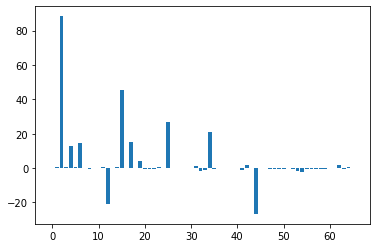

In [310]:
# get importance
importance = lr.coef_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [312]:
regressor = DecisionTreeRegressor(random_state = 0,
                                 criterion='mse', max_depth=50,
                                  max_leaf_nodes=30,
                                  min_samples_leaf=100, min_samples_split=100) 
regressor.fit(X_train, y_train)
rmse_dt_train = np.sqrt(mse(y_train, regressor.predict(X_train)))
rmse_dt_test = np.sqrt(mse(y_test, regressor.predict(X_test)))
print("Mean Squared Error for training {}".format(rmse_dt_train))
print("Mean Squared Error for testing {}".format(rmse_dt_test))

Mean Squared Error for training 12.73201893966553
Mean Squared Error for testing 13.074203793247849


regularization

In [321]:
model = ElasticNet()
# define model evaluation method
# define grid
grid = dict()
grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
grid['l1_ratio'] = arange(0, 1, 0.01)
# define search
search = GridSearchCV(model, grid, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)
# perform the search
results = search.fit(X_train,y_train)
# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

KeyboardInterrupt: 

join game_past_data table to the clusters of players